In [22]:
import pandas as pd
import csv
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import numpy as np
from sklearn.cluster import KMeans
import networkx as nx
import operator
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

##################################
# Data preparation
##################################

######### Read input files
def readInput(path):
    absolutePath = path
    data = pd.read_csv(os.path.join(absolutePath,"cleanFeatures.csv"))
    data.drop(['Unnamed: 0'], axis=1,inplace = True)
    return data


######### Split train test set
def split(data):
    X = data.drop(['Target'],axis=1)
    y = data['Target']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=2019)
    return (X_train, X_test, y_train, y_test)

##################################
# Method 1: PCA + K-Means
##################################

######### PCA
def PCA(X_noID):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X_noID)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])

    ######### PCA Visualization
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.style.use('ggplot')
    f1 = principalDf['principal component 1'].values
    f2 = principalDf['principal component 2'].values
    plt.scatter(f1, f2, c='black', s=7)
    plt.show()

    ######### PCA Data split
    XPCA = np.array(list(zip(f1, f2)))
    return XPCA, principalComponents


######### Kmeans Clustering
def Kmeans(X_train_PCA, X_test_PCA, X_train, X_test, y_train, y_test):
    from sklearn.cluster import KMeans

    n_clusters = 3
    kmeans = KMeans(n_clusters,random_state = 2019)
    km = kmeans.fit(X_train_PCA)          # train on the training set only
    labels = kmeans.predict(X_test_PCA)   # should predict on the test set
    centroids = kmeans.cluster_centers_

    # Write output summary
    text_file = open("KmeansOutput.txt", "w")

    #############################################
    # Assume Cluster 0 is disease cluster
    #############################################
    ######### Assume positive is disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] == 0) and (y_test[i] == 1)):    # Label is in cluster 0 (assume the disease cluster), test is 1 (disease cluster)
            TP += 1
        if((labels[i] == 0) and (y_test[i] == 0)):    # Label is in cluster 0 (assume the disease cluster), test is 0 (not in disease cluster)
            FP += 1
        if((labels[i] != 0) and (y_test[i] == 1)):    # Label is not in cluster 0 (assume the disease cluster), test is 1 (disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 0 is considered as target, disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")
    ######### Assume positive is non-disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] != 0) and (y_test[i] == 0)):    # Label is not in cluster 0 (assume the disease cluster), test is 0 (non disease cluster)
            TP += 1
        if((labels[i] != 0) and (y_test[i] == 1)):    # Label is not in cluster 0 (assume the disease cluster), test is 1 (disease cluster)
            FP += 1
        if((labels[i] == 0) and (y_test[i] == 0)):    # Label is in cluster 0 (assume the disease cluster), test is 0 (non disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 0 is considered as target, non-disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")

    #############################################
    # Assume Cluster 0 is non disease cluster
    #############################################
    ######### Assume positive is disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] != 0) and (y_test[i] == 1)):    # Label is not in cluster 0 (disease cluster), test is 1 (disease cluster)
            TP += 1
        if((labels[i] != 0) and (y_test[i] == 0)):    # Label is not in cluster 0 (disease cluster), test is 0 (not in disease cluster)
            FP += 1
        if((labels[i] == 0) and (y_test[i] == 1)):    # Label is in cluster 0 (non disease cluster), test is 1 (disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 0 is considered as non target, disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")
    ######### Assume positive is non-disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] == 0) and (y_test[i] == 0)):    # Label is in cluster 0 (non disease cluster), test is 0 (non disease cluster)
            TP += 1
        if((labels[i] == 0) and (y_test[i] == 1)):    # Label is in cluster 0 (non disease cluster), test is 1 (disease cluster)
            FP += 1
        if((labels[i] != 0) and (y_test[i] == 0)):    # Label is not in cluster 0 (disease cluster), test is 0 (non disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 0 is considered as non target, non-disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")

    #############################################
    # Assume Cluster 1 is disease cluster
    #############################################
    ######### Assume positive is disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] == 1) and (y_test[i] == 1)):    # Label is in cluster 1 (assume the disease cluster), test is 1 (disease cluster)
            TP += 1
        if((labels[i] == 1) and (y_test[i] == 0)):    # Label is in cluster 1 (assume the disease cluster), test is 0 (not in disease cluster)
            FP += 1
        if((labels[i] != 1) and (y_test[i] == 1)):    # Label is not in cluster 1 (assume the disease cluster), test is 1 (disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 1 is considered as target, disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")
    ######### Assume positive is non-disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] != 1) and (y_test[i] == 0)):    # Label is not in cluster 1 (assume the disease cluster), test is 0 (non disease cluster)
            TP += 1
        if((labels[i] != 1) and (y_test[i] == 1)):    # Label is not in cluster 1 (assume the disease cluster), test is 1 (disease cluster)
            FP += 1
        if((labels[i] == 1) and (y_test[i] == 0)):    # Label is in cluster 1 (assume the disease cluster), test is 0 (non disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 1 is considered as target, non-disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")

    #############################################
    # Assume Cluster 1 is non disease cluster
    #############################################
    ######### Assume positive is disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] != 1) and (y_test[i] == 1)):    # Label is not in cluster 1 (disease cluster), test is 1 (disease cluster)
            TP += 1
        if((labels[i] != 1) and (y_test[i] == 0)):    # Label is not in cluster 1 (disease cluster), test is 0 (not in disease cluster)
            FP += 1
        if((labels[i] == 1) and (y_test[i] == 1)):    # Label is in cluster 1 (non disease cluster), test is 1 (disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 1 is considered as non target, disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")
    ######### Assume positive is non-disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] == 1) and (y_test[i] == 0)):    # Label is in cluster 1 (non disease cluster), test is 0 (non disease cluster)
            TP += 1
        if((labels[i] == 1) and (y_test[i] == 1)):    # Label is in cluster 1 (non disease cluster), test is 1 (disease cluster)
            FP += 1
        if((labels[i] != 1) and (y_test[i] == 0)):    # Label is not in cluster 1 (disease cluster), test is 0 (non disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 1 is considered as non target, non-disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")

    #############################################
    # Assume Cluster 2 is disease cluster
    #############################################
    ######### Assume positive is disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] == 2) and (y_test[i] == 1)):    # Label is in cluster 2 (assume the disease cluster), test is 1 (disease cluster)
            TP += 1
        if((labels[i] == 2) and (y_test[i] == 0)):    # Label is in cluster 2 (assume the disease cluster), test is 0 (not in disease cluster)
            FP += 1
        if((labels[i] != 2) and (y_test[i] == 1)):    # Label is not in cluster 2 (assume the disease cluster), test is 1 (disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 2 is considered as target, disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")
    ######### Assume positive is non-disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] != 2) and (y_test[i] == 0)):    # Label is not in cluster 2 (assume the disease cluster), test is 0 (non disease cluster)
            TP += 1
        if((labels[i] != 2) and (y_test[i] == 1)):    # Label is not in cluster 2 (assume the disease cluster), test is 1 (disease cluster)
            FP += 1
        if((labels[i] == 2) and (y_test[i] == 0)):    # Label is in cluster 2 (assume the disease cluster), test is 0 (non disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 2 is considered as target, non-disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")

    #############################################
    # Assume Cluster 2 is non disease cluster
    #############################################
    ######### Assume positive is disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] != 2) and (y_test[i] == 1)):    # Label is not in cluster 2 (disease cluster), test is 1 (disease cluster)
            TP += 1
        if((labels[i] != 2) and (y_test[i] == 0)):    # Label is not in cluster 2 (disease cluster), test is 0 (not in disease cluster)
            FP += 1
        if((labels[i] == 2) and (y_test[i] == 1)):    # Label is in cluster 2 (non disease cluster), test is 1 (disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 2 is considered as non target, disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")
    ######### Assume positive is non-disease
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(labels)):
        if((labels[i] == 2) and (y_test[i] == 0)):    # Label is in cluster 2 (non disease cluster), test is 0 (non disease cluster)
            TP += 1
        if((labels[i] == 2) and (y_test[i] == 1)):    # Label is in cluster 2 (non disease cluster), test is 1 (disease cluster)
            FP += 1
        if((labels[i] != 2) and (y_test[i] == 0)):    # Label is not in cluster 2 (disease cluster), test is 0 (non disease cluster)
            FN += 1
    F1 = (2*TP)/(2*TP+FP+FN)
    TN = len(data) - TP - FP - FN
    ACC = (TP+TN) / len(data)
    text_file.write("When cluster 2 is considered as non target, non-disease is considered as positive, f1 score is " + str(F1) + ", accuracy score is " + str(ACC) + "\n")
    text_file.close()
    
    return centroids

######### Visualize the results (Here we have many redundant codes)
def KMeansVisualization(principalComponents,centroids):
    #
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
    #
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = principalComponents[:, 0].min() - 1, principalComponents[:, 0].max() + 1
    y_min, y_max = principalComponents[:, 1].min() - 1, principalComponents[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    #
    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    #
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')
    plt.plot(principalComponents[:, 0], principalComponents[:, 1], 'k.', markersize=2)
    #
    # Plot the centroids as a white X
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [23]:
path = "/Users/limengyang/Workspaces/Module-Detection/"
data = readInput(path)
X_train, X_test, y_train, y_test = split(data)

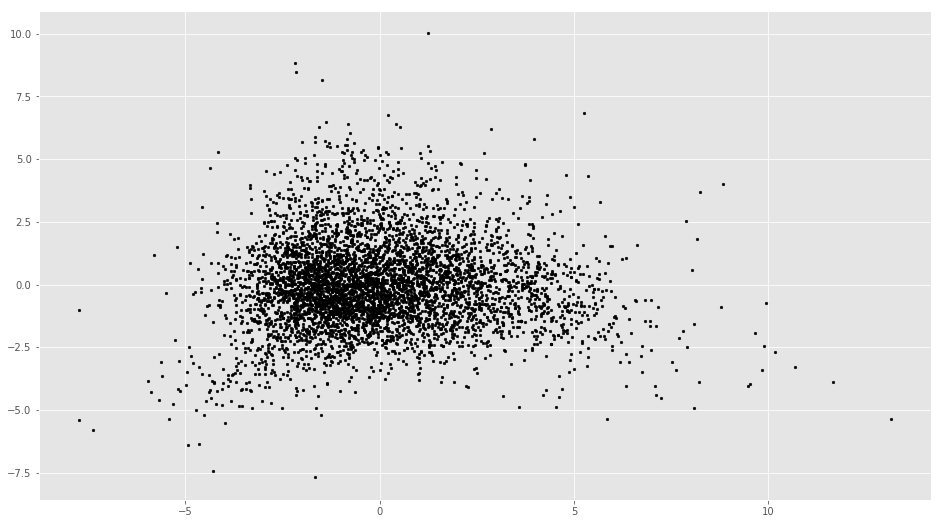

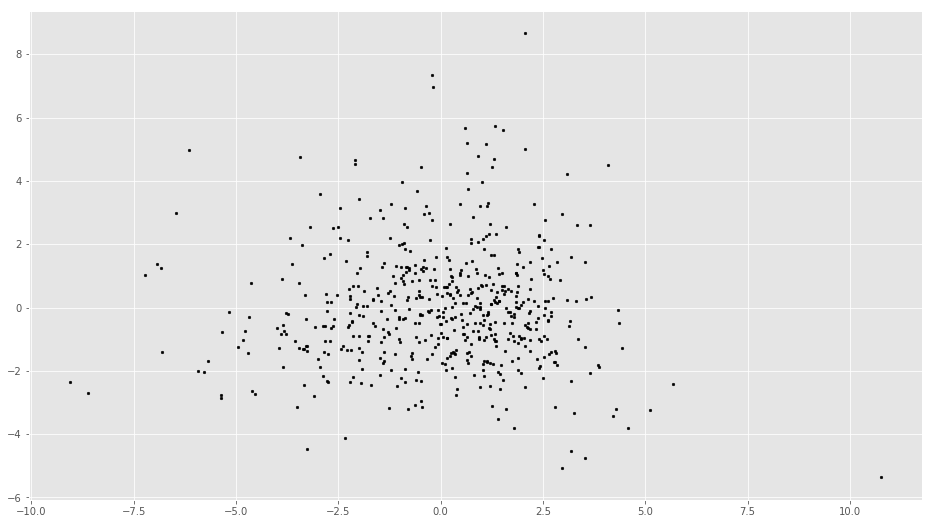

[[-1.44623185 -0.91023441]
 [ 2.8859163  -0.46109373]
 [-0.43768822  2.04157568]]


In [24]:
# PCA
X_train_PCA, principalComponents_train = PCA(X_train.drop(['ProteinID'],axis = 1))
X_test_PCA, principalComponents_test = PCA(X_test.drop(['ProteinID'],axis = 1))
centroids = Kmeans(X_train_PCA, X_test_PCA, X_train, X_test, y_train.tolist(),y_test.tolist())

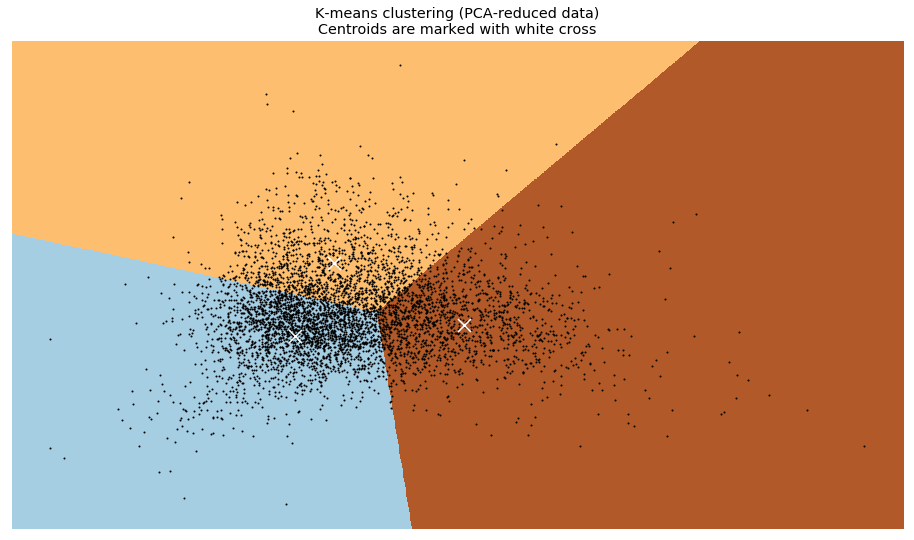

In [26]:
KMeansVisualization(principalComponents_train, centroids)

In [5]:
 n_clusters = 3
kmeans = KMeans(n_clusters,random_state = 2019)
km = kmeans.fit(X_train_PCA)          # train on the training set only

In [6]:
kmeans.cluster_centers_

array([[-1.44290605, -0.90252666],
       [-0.43991069,  2.06083783],
       [ 2.87920594, -0.45881339]])

In [7]:
labels = kmeans.predict(X_test_PCA)   # should predict on the test set

In [9]:
kmeans.cluster_centers_

array([[-1.44290605, -0.90252666],
       [-0.43991069,  2.06083783],
       [ 2.87920594, -0.45881339]])

In [20]:
centroids

In [18]:
Kmeans(X_train_PCA, X_test_PCA, X_train, X_test, y_train.tolist(),y_test.tolist())

[[-1.44290481 -0.90250652]
 [-0.43991195  2.06081363]
 [ 2.87920506 -0.45882425]]


In [25]:
centroids

array([[-1.44623185, -0.91023441],
       [ 2.8859163 , -0.46109373],
       [-0.43768822,  2.04157568]])